In [2]:
import sys
sys.path.append('../lib')
import tensorflow as tf
from table_detection import TableNet, get_mask_from_bounding_box
from utils import *
import cv2
from shutil import copyfile
import os
import numpy as np
import imutils
import tqdm
from utils import *
%matplotlib inline
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks
from sklearn.preprocessing import Normalizer

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
model = TableNet.build()
latest = tf.train.latest_checkpoint('models/2020_09_24')
model.load_weights(latest)

In [5]:
class TableMask:
    
    def __init__(self,image,predicted_mask):
        self.image = image
        self.predicted_mask = predicted_mask
        self.original_image_shape = (image.shape[1],image.shape[0])
        self.corrected_mask = None
        self.resized_bounding_box = None
        self.original_bounding_box = None
        self.image_with_bounding_box = None
        self.cropped_table = None
    
    @staticmethod
    def get_coef(myimage):
        shape = myimage.shape
        return myimage.sum()/(shape[0]*shape[1])
    
    @staticmethod
    def process_number(x):
        n=round(x)
        if n%2==1:
            return n
        else:
            return n+1

    def get_predicted_area_ratio(self):
        shape = self.corrected_mask.shape
        return (self.corrected_mask==255).sum()/(shape[0]*shape[1]*3)
    
    def get_bounding_box_coordinates(self):
        se1 = cv2.getStructuringElement(cv2.MORPH_RECT, (30,30))
        mask1 = cv2.morphologyEx(self.predicted_mask.copy(), cv2.MORPH_OPEN, se1)
        se2 = np.ones((10,10),np.uint8)
        mask2  = cv2.dilate(mask1, se2)
        mask = (1*(mask2==255)).astype('uint8')
        out = np.logical_and(self.predicted_mask.copy(),mask).astype('uint8')
        se3 = cv2.getStructuringElement(cv2.MORPH_RECT, (10,10))
        cleaned_out = cv2.morphologyEx(out, cv2.MORPH_OPEN, se1)
        cnts = cv2.findContours(cleaned_out.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        try:
            c = max(cnts, key=cv2.contourArea)
            rect = cv2.boundingRect(c)
            x,y,w,h = rect
            self.resized_bounding_box = rect
        except:
            self.resized_bounding_box = (0,0,0,0)

    def generate_corrected_mask(self):
        self.corrected_mask = cv2.resize(get_mask_from_bounding_box(self.resized_bounding_box,(256,256,3)),self.original_image_shape)
    
    def get_bounding_box_coordinates_on_original_image(self):
        point1_org = (np.where(self.corrected_mask==255)[1][0] , np.where(self.corrected_mask==255)[0][0])
        point2_org = (np.where(self.corrected_mask==255)[1][-1] , np.where(self.corrected_mask==255)[0][-1])
        self.original_bounding_box = (point1_org[0],point1_org[1],point2_org[0]-point1_org[0],point2_org[1]-point1_org[1])
    
    def draw_bounding_box(self):
        x,y,w,h = self.original_bounding_box
        self.image_with_bounding_box = cv2.rectangle(self.image.copy(),(x,y),(x+w,y+h),(0,255,0),10)
        
        
    def get_cropped_image(self):
        x,y,w,h = self.original_bounding_box
        return self.image[y:y+h,x:x+w]
    
    
class Pipeline:
    def __init__(self,model,image):
        self.model = model
        self.images = [image]
        self.tm_list = []
        self.predicted_table_masks = []
        self.predicted_column_masks = []
        self.predicted_table_mask = None
        self.predicted_column_mask = None
    
    @staticmethod
    def iou(gt_mask,pred_mask):
        intersection = np.logical_and(gt_mask,pred_mask).sum()
        union = np.logical_or(gt_mask,pred_mask).sum()
        return intersection/union
    
    def predict(self):
        img_tensor, shape = get_image_tensor_from_image_array(self.images[-1])
        image = tf.expand_dims(img_tensor,axis=0)
        predicted_table_mask, predicted_column_mask = get_masks(self.model,image)
        self.predicted_table_masks.append(predicted_table_mask)
        self.predicted_column_masks.append(predicted_column_mask)
    
    def process_prediction(self):
        bw_mask = 255*self.predicted_table_masks[-1].numpy().reshape(256,256)
        self.tm_list.append(TableMask(np.uint8(self.images[-1].numpy()),np.uint8(bw_mask)))
        self.tm_list[-1].get_bounding_box_coordinates()
        self.tm_list[-1].generate_corrected_mask()
        self.tm_list[-1].get_bounding_box_coordinates_on_original_image()
        
    def get_predicted_area_ratio(self):
        image = cv2.cvtColor(self.tm_list[-1].corrected_mask,cv2.COLOR_RGB2GRAY)
        shape = image.shape
        return (image==255).sum()/(shape[0]*shape[1])
    
    def predicted_area(self):
        return self.tm_list[-1].get_predicted_area_ratio()
    
    def run(self, pred_area_threshold, loop_until_converge=True):
        while True:
            self.predict()
            self.process_prediction()
            if self.predicted_area()>pred_area_threshold or loop_until_converge==False:
                break
            else:
                self.images.append(tf.convert_to_tensor(self.tm_list[-1].get_cropped_image()))
                #plt.figure()
                #plt.imshow(self.images[-1])
                #plt.show()
        
                
    def get_final_prediction_bbx(self):
        rect_list = [tm.original_bounding_box for tm in self.tm_list]
        bbx = rect_list[0]
        x,y,w,h = bbx
        for i in range(1,len(self.tm_list)):
            bbx = get_absolute_coordinates(bbx,rect_list[i])
        return bbx
    
    def get_predicted_table_mask(self):
        bbx = self.get_final_prediction_bbx()
        self.predicted_table_mask = get_mask_from_bounding_box(bbx,self.images[0].shape)
        

In [6]:
images = [os.path.join('../data/line_detection_data/',file) for file in os.listdir('../data/line_detection_data/') if file.split('.')[-1]=='jpg']

In [19]:
image_path = os.path.join('../data/ocr/',"8413671001757.nutrition.jpg")
image = plt.imread(image_path)
rotated = cv2.rotate(image,cv2.ROTATE_90_COUNTERCLOCKWISE)

In [20]:
def get_biggest_gap_index(index_list):
    steps = [x-y for y,x in zip(index_list,index_list[1:])]
    index_where_biggest_gap = np.where(steps==max(steps))[0][0]
    return index_list[index_where_biggest_gap], index_list[index_where_biggest_gap+1]
def runningMean(x, N):
    y = np.zeros((len(x),))
    for ctr in range(len(x)):
         y[ctr] = np.sum(x[ctr:(ctr+N)])
    return y/N

In [48]:
pipeline = Pipeline(model,tf.convert_to_tensor(rotated))
pipeline.run(0.5)
column_mask = pipeline.predicted_column_masks[0].numpy().reshape(256,256).astype(np.uint8)
original_image = pipeline.images[0].numpy().astype(np.uint8).copy()

kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(1,10))
close = cv2.morphologyEx(column_mask,cv2.MORPH_CLOSE,kernel1)
close = np.logical_or(close,column_mask).astype('uint8')
div = np.float32(column_mask)/(close)

kernelx = cv2.getStructuringElement(cv2.MORPH_RECT,(1,20))
dx = cv2.Sobel(div,cv2.CV_16S,1,0)
dx = cv2.convertScaleAbs(dx)
cv2.normalize(dx,dx,0,255,cv2.NORM_MINMAX)
ret,close = cv2.threshold(dx,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
close_sum = close.sum(axis=1)
indexes = np.where(close_sum>close_sum.max()*0.8)[0]
start, end = get_biggest_gap_index(indexes)
close[:start]=0
close[end:] = 0
processed_column_mask = close[start:end]

window_size=10
distance=5
normalizer = Normalizer()
vertical_sum = processed_column_mask.sum(axis=0)
vertical_sum_mv_avg = runningMean(vertical_sum,window_size)
signal = normalizer.fit_transform([vertical_sum_mv_avg])[0]
peaks, _ = find_peaks(signal, prominence=signal.std(), distance = distance)
signal_peaks = peaks #Remove last peak as it is not significant
corrected_peaks = [peak+(window_size//2) for peak in signal_peaks]
peaks = [x*original_image.shape[1]//256 for x in corrected_peaks]

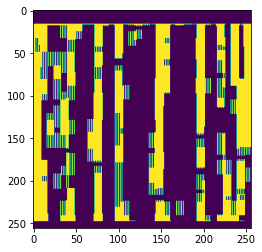

In [50]:
plt.imshow(close)

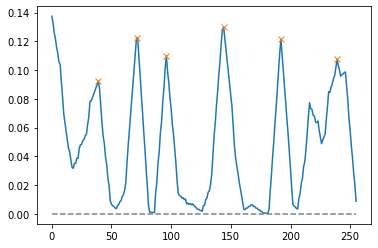

In [49]:
plt.plot(signal)
plt.plot(signal_peaks, signal[signal_peaks], "x")
plt.plot(np.zeros_like(signal), "--", color="gray")

In [44]:
def find_column_areas(self):
    indexes = self.peaks.copy()
    indexes.insert(0,0)
    for i,col_index in enumerate(indexes):
        if i==len(indexes)-1:
            self.column_areas.append(self.original_image[:,indexes[i]:]) 
        else:
            self.column_areas.append(self.original_image[:,indexes[i]:indexes[i+1]])

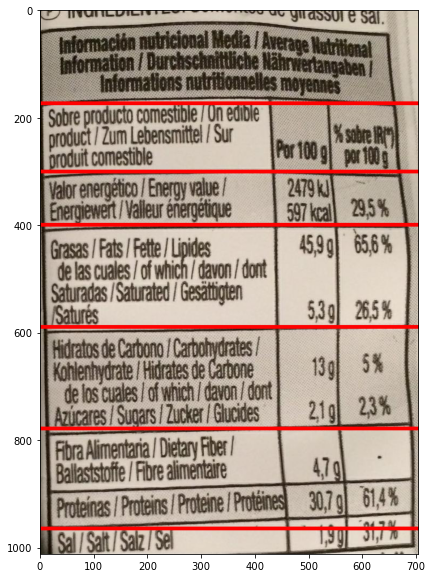

In [52]:
original_image = image.copy()
for i,peak in enumerate(peaks):
    cv2.line(image, pt1=(0,peak), pt2=(original_image.shape[1],peak), color=(255,0,0), thickness=5)
plt.figure(figsize=(20,10))
plt.imshow(original_image,cmap='gray')

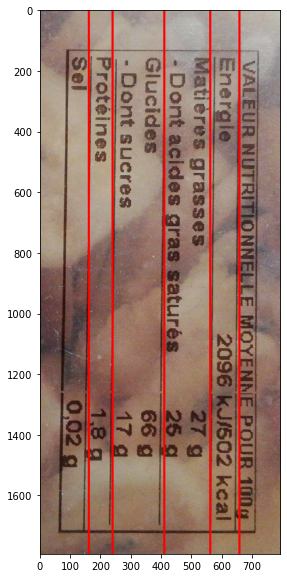

In [17]:
original_image = pipeline.images[0].numpy().astype(np.uint8).copy()
for i,peak in enumerate(peaks):
    cv2.line(original_image, pt1=(peak,0), pt2=(peak,original_image.shape[0]), color=(255,0,0), thickness=5)
plt.figure(figsize=(20,10))
plt.imshow(original_image,cmap='gray')

In [18]:
column_areas = []

In [19]:
original_image = pipeline.images[0].numpy().astype(np.uint8).copy()
for i,col_index in enumerate(peaks):
        if i==len(peaks)-1:
            column_areas.append(original_image[:,peaks[i]:]) 
        else:
            column_areas.append(original_image[:,peaks[i]:peaks[i+1]])

In [20]:
image = column_areas[1]

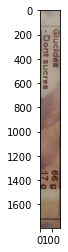

In [21]:
plt.imshow(image)

In [22]:
pipeline = Pipeline(model,tf.convert_to_tensor(image))
pipeline.run(0.1)

In [23]:
column_mask = pipeline.predicted_column_masks[0].numpy().reshape(256,256).astype(np.uint8)
original_image = pipeline.images[0].numpy().astype(np.uint8).copy()

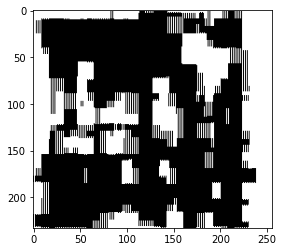

In [24]:
kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(1,10))
close = cv2.morphologyEx(column_mask,cv2.MORPH_CLOSE,kernel1)
close = np.logical_or(close,column_mask).astype('uint8')
div = np.float32(column_mask)/(close)

kernelx = cv2.getStructuringElement(cv2.MORPH_RECT,(1,5))
dx = cv2.Sobel(div,cv2.CV_16S,1,0)
dx = cv2.convertScaleAbs(dx)
cv2.normalize(dx,dx,0,255,cv2.NORM_MINMAX)
ret,close = cv2.threshold(dx,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
close_sum = close.sum(axis=1)
indexes = np.where(close_sum>close_sum.max()*0.9)[0]
start, end = get_biggest_gap_index(indexes)
close[:start]=0
close[end:] = 0
processed_column_mask = close[start:end]

plt.imshow(processed_column_mask,cmap='gray')

window_size=10
distance=5
normalizer = Normalizer()
vertical_sum = processed_column_mask.sum(axis=0)
vertical_sum_mv_avg = runningMean(vertical_sum,window_size)
signal = normalizer.fit_transform([vertical_sum_mv_avg])[0]
peaks, _ = find_peaks(signal, prominence=signal.std(), distance = distance)
signal_peaks = peaks[:-1] #Remove last peak as it is not significant
corrected_peaks = [peak+(window_size//2) for peak in signal_peaks]
peaks = [x*original_image.shape[1]//256 for x in corrected_peaks]

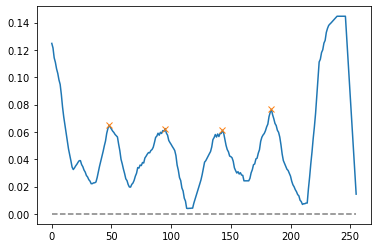

In [25]:
plt.plot(signal)
plt.plot(signal_peaks, signal[signal_peaks], "x")
plt.plot(np.zeros_like(signal), "--", color="gray")

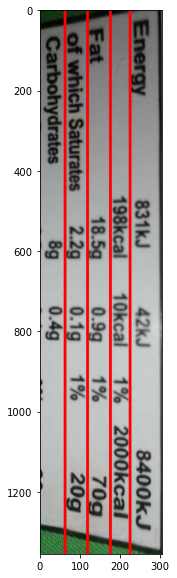

In [26]:
original_image = pipeline.images[0].numpy().astype(np.uint8).copy()
for i,peak in enumerate(peaks):
    cv2.line(original_image, pt1=(peak,0), pt2=(peak,original_image.shape[0]), color=(255,0,0), thickness=5)
plt.figure(figsize=(20,10))
plt.imshow(original_image,cmap='gray')

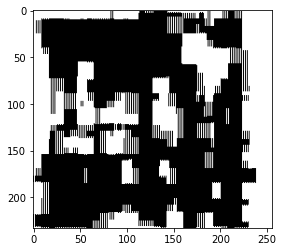

In [27]:
plt.imshow(processed_column_mask,cmap='gray')

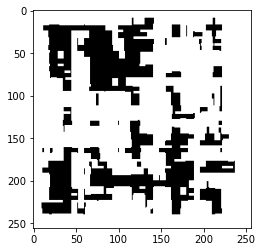

In [34]:
mask = np.zeros((column_mask.shape),np.uint8)
# Définir le pas du kernel >20 pour que les lignes verticales soient plus accentuées 

kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,1))
close = cv2.morphologyEx(column_mask,cv2.MORPH_CLOSE,kernel1)
div = np.float32(column_mask)/(close)

kernelx = cv2.getStructuringElement(cv2.MORPH_RECT,(3,1))
dx = cv2.Sobel(div,cv2.CV_16S,1,0)
dx = cv2.convertScaleAbs(dx)
cv2.normalize(dx,dx,0,255,cv2.NORM_MINMAX)
ret,close = cv2.threshold(dx,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

close = np.logical_or(close,column_mask).astype('uint8')

kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT,(1,5))
close = cv2.morphologyEx(column_mask,cv2.MORPH_OPEN,kernel1)
div = np.float32(column_mask)/(close)


kernelx = cv2.getStructuringElement(cv2.MORPH_RECT,(1,5))
dx = cv2.Sobel(div,cv2.CV_16S,1,0)
dx = cv2.convertScaleAbs(dx)
cv2.normalize(dx,dx,0,255,cv2.NORM_MINMAX)


kernely = cv2.getStructuringElement(cv2.MORPH_RECT,(5,1))
#plt.imshow(dx,cmap='gray')
ret,close = cv2.threshold(dx,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
close = cv2.morphologyEx(close,cv2.MORPH_DILATE,kernely,iterations = 1)
plt.imshow(close,cmap='gray')
close_sum = close.sum(axis=1)
indexes = np.where(close_sum==close_sum.max())[0]
start, end = get_biggest_gap_index(indexes)
close[:start]=0
close[end:] = 0
processed_column_mask = close[start:end]


window_size=10
distance=5
normalizer = Normalizer()
vertical_sum = processed_column_mask.sum(axis=0)
vertical_sum_mv_avg = runningMean(vertical_sum,window_size)
signal = normalizer.fit_transform([vertical_sum_mv_avg])[0]
peaks, _ = find_peaks(signal, prominence=signal.std(), distance = distance)
signal_peaks = peaks[:-1] #Remove last peak as it is not significant
corrected_peaks = [peak+(window_size//2) for peak in signal_peaks]
peaks = [x*original_image.shape[1]//256 for x in corrected_peaks]

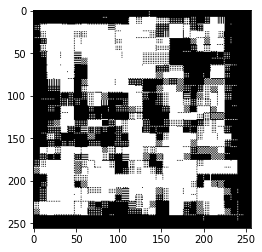

In [35]:
plt.imshow(column_mask,cmap='gray')

In [36]:
original_image = pipeline.images[0].numpy().astype(np.uint8).copy()

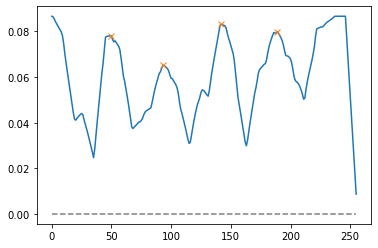

In [37]:
plt.plot(signal)
plt.plot(signal_peaks, signal[signal_peaks], "x")
plt.plot(np.zeros_like(signal), "--", color="gray")

In [38]:
for i,peak in enumerate(peaks):
    cv2.line(original_image, pt1=(peak,0), pt2=(peak,original_image.shape[0]), color=(255,0,0), thickness=5)

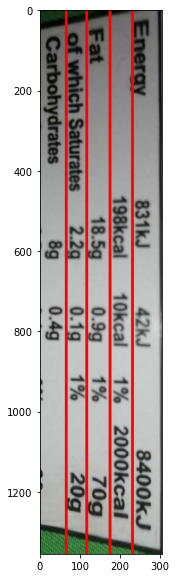

In [39]:
plt.figure(figsize=(20,10))
plt.imshow(original_image,cmap='gray')

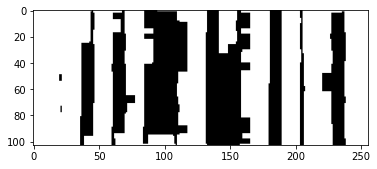

In [45]:
plt.imshow(processed_column_mask,cmap='gray')